In [2]:
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import cv2
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing
from scipy.signal import wiener

In [5]:
def show_images(img1, img2, title1='', title2='', cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title(title1)
    plt.imshow(img1, cmap=cmap)


    plt.subplot(122)
    plt.title(title2)
    plt.imshow(img2, cmap=cmap)

In [7]:
def load_image_pydicom(img_path, voi_lut=False, modality_lut=False, windowing=False, return_ds=False):
    dataset = pydicom.dcmread(img_path)
    img = dataset.pixel_array
    if voi_lut:
        img = apply_voi_lut(img, dataset)
    if modality_lut:
        img = apply_modality_lut(img, dataset)
    if windowing:
        img = apply_windowing(img, dataset)
    if dataset.PhotometricInterpretation == "MONOCHROME1":
        img = np.amax(img) - img
    if return_ds:
        return img, dataset
    else:
        return img

In [10]:
def dicom_image_segmentation(img, show_thres=False):
    
    _, img_thres = cv2.threshold(img, 0.1, 255, cv2.THRESH_BINARY)
    
    
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
#     opening = cv2.morphologyEx(img_thres, cv2.MORPH_OPEN, kernel)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#     closing = closing.astype(np.uint8)
    
    kernel_erosion = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    erosion = cv2.erode(img_thres, kernel_erosion, iterations=4)
    
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    dilation = cv2.dilate(erosion, kernel_dilate)
    
    dilation = dilation.astype(np.uint8)
    
    if show_thres:
        plt.figure(figsize=(12, 6))
        plt.imshow(dilation, cmap='gray')
    
    img_out = cv2.bitwise_and(img, img, mask=dilation)
    
    return img_out

In [80]:
def clahe_filter(img, limit=6.0, gridSize=(8,8)):
    
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=gridSize)
    img_clahe = clahe.apply(img) 
    
    return img_clahe
    

In [9]:
image_path = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/1.dicom"
image_path2 = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/2.dicom"
image_path3 = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/3.dcm"
image_path4a = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/4a.dicom"
image_path4b = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/4b.dicom"
image_path5a = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/5a.dcm"
image_path5b = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/5b.dcm"
image_path6 = "/home/dimatkchnk/praca_dyplomowa/samples-from-databases/dicom/6.dcm"

In [37]:
img = load_image_pydicom(image_path3)
img_voi = load_image_pydicom(image_path2, voi_lut=True)

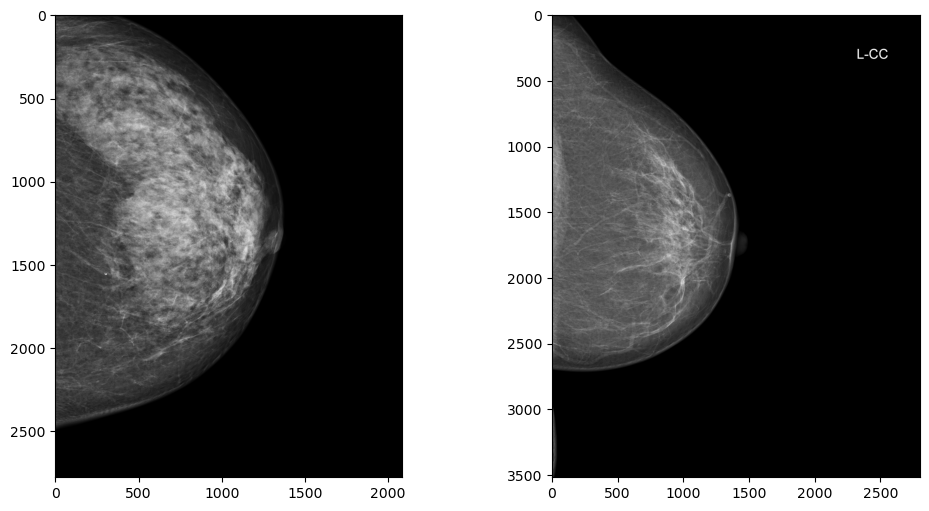

In [38]:
show_images(img, img_voi)

In [39]:
img_out = dicom_image_segmentation(img_voi)

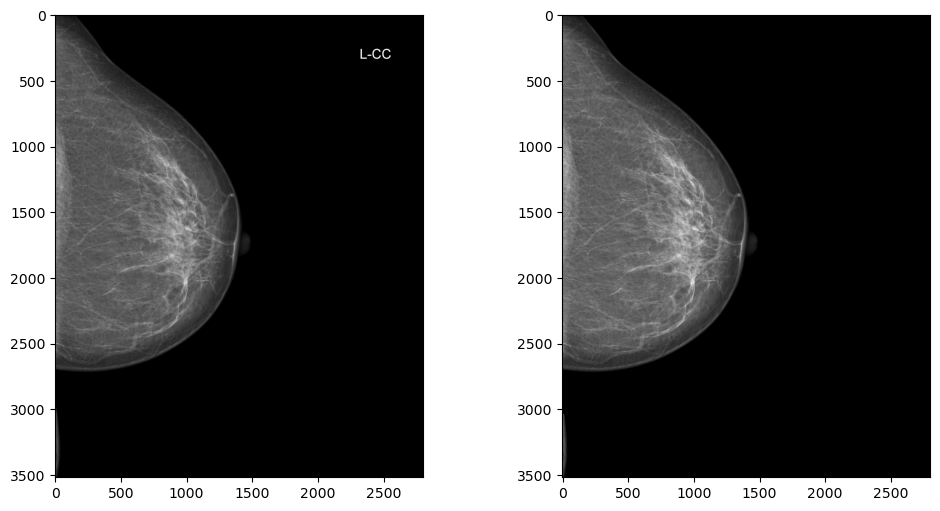

In [84]:
show_images(img_voi, img_out)

In [85]:
wiener_img = wiener(img_out, (3,3), 0.5)

/usr/local/lib64/python3.11/site-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/usr/local/lib64/python3.11/site-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


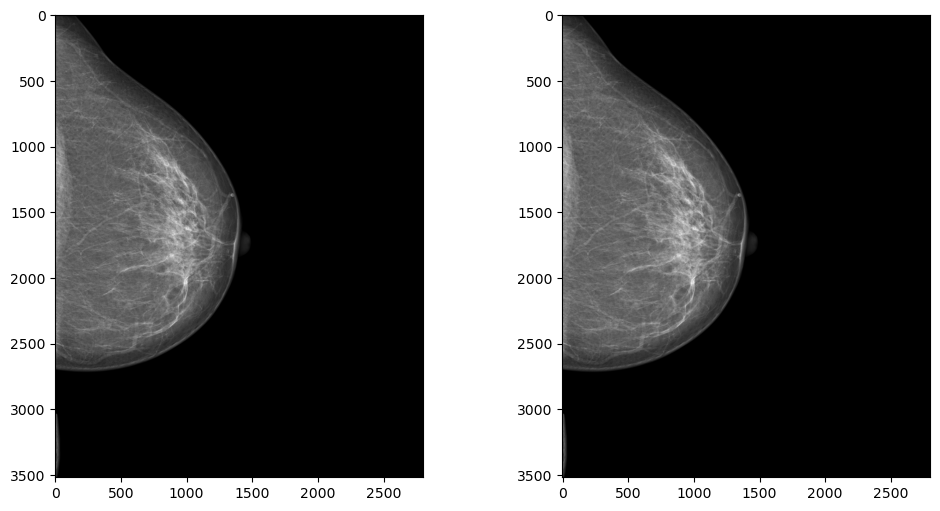

In [87]:
show_images(img_out, wiener_img)

In [90]:
img_out.shape

(3518, 2800)

In [91]:
wiener_img.shape

(3518, 2800)

In [88]:
psnr = cv2.PSNR(img_out, wiener_img)
print(f"{psnr} db")

error: OpenCV(4.7.0) /io/opencv/modules/core/src/norm.cpp:1279: error: (-215:Assertion failed) _src1.type() == _src2.type() in function 'PSNR'


In [81]:
img_clahe = clahe_filter(img_out)

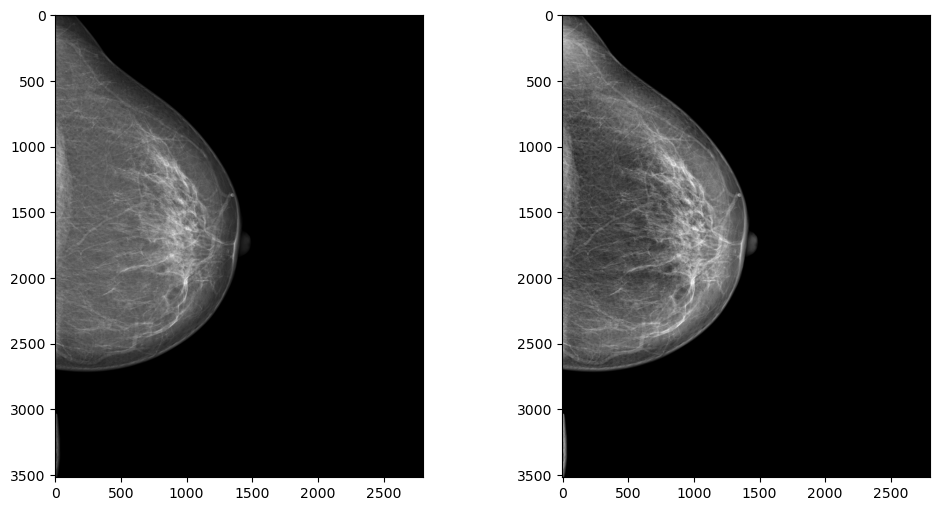

In [82]:
show_images(img_out, img_clahe)

In [83]:
psnr = cv2.PSNR(img_out, img_clahe)
print(f"{psnr} db")

-11.922048710848847 db
